In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import onnx
from onnx2pytorch import ConvertModel
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple
from collections import OrderedDict

In [3]:
onnx_model = onnx.load("mnist-net_256x4.onnx")
pytorch_model = ConvertModel(onnx_model)

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
state_dict = pytorch_model.state_dict()
my_state_dict = {}
for i, key in enumerate(state_dict):
    actual_index = i * 2
    my_state_dict[f"{actual_index}.bias"] = state_dict[f"_initializer_layers_{actual_index}_bias"]
    my_state_dict[f"{actual_index}.weight"] = state_dict[f"_initializer_layers_{actual_index}_weight"]
    if actual_index == 8:
        break
    
nn.load_state_dict(my_state_dict)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


<All keys matched successfully>

In [4]:
parameter_list = list(nn.parameters())
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

In [5]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [6]:
transform = Compose([ToTensor()])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

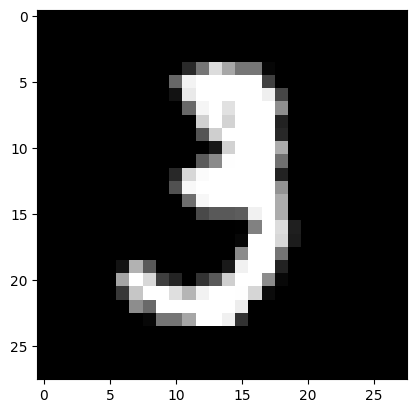

The label is 3
NN classifies image correctly as 3


In [7]:
image_index = 10

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")

In [8]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0].detach().cpu().numpy()
    out_ub = nn_layer_out_bounds[-1][1].detach().cpu().numpy()
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

In [9]:
def load_vnnlib_bounds(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=data_type).reshape(input_shape).to(device)
    data_max = torch.tensor(ubs, dtype=data_type).reshape(input_shape).to(device)

    return [data_min, data_max]

vnnlib_path = 'prop_0_0.03.vnnlib'
input_bounds = load_vnnlib_bounds(vnnlib_path, [784,], 10)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/vnnlib/compat.py:283: UserWarning: literal negation does not strictly follow SMT-LIB
  ast_node = parse_file(vnnlib_filename, strict=False)


In [10]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model)
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [11]:
def load_vnnlib_spec_for_auto_lirpa(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]

    bnds = np.array(bnds)
    lbs = bnds[:, 0]
    ubs = bnds[:, 1]

    data_min = torch.tensor(lbs, dtype=torch.float32).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=torch.float32).reshape(input_shape)
    center = 0.5 * (data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)

    return x


onnx_path = 'mnist-net_256x4.onnx'
vnnlib_path = 'prop_0_0.03.vnnlib'
model = load_onnx_model(onnx_path, [1, 1, 1, 784])
x = load_vnnlib_spec_for_auto_lirpa(vnnlib_path, [1, 1, 1, 784], 10)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/model.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.experimental and inputs[0].shape[self.batch_dim] > 1:
/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/auto_LiRPA/parse_graph.py:154: FutureWarning: 'torch.onnx.symbolic_helper._set_opset_version' is deprecated in version 1.13 and will be removed in 2.0. Please remove its usage and avoid setting internal variables directly.
  _set_opset_version(12)


In [12]:
def get_layers(model):
    return [l for l in model.nodes() if l.perturbed]

In [13]:
def get_intermediate_bounds(model):
    """
    Returns a dictionary containing the concrete lower and upper bounds of each layer.
    
    Implemented own method to filter out bounds for weight matrices.
    
    Only call this method after compute_bounds()!
    """
    od = OrderedDict()
    for l in get_layers(model):
        if hasattr(l, 'lower'):
            od[l.name] = (l.lower, l.upper)
            
    return od

In [14]:
model.compute_bounds(x=(x,), method='ibp')
model.compute_bounds(x=(x,), method='crown')

(tensor([[-16.1574, -13.2932, -17.4020, -26.5492, -17.5962, -16.9601, -15.3861,
          -17.6454, -20.9628, -15.7071]], grad_fn=<ViewBackward0>),
 tensor([[13.8042, 12.8868, 11.2402,  7.7739, 14.1580, 12.1219, 15.4775, 13.8468,
          12.8768, 15.7155]], grad_fn=<ViewBackward0>))

In [15]:
bounds_dict_crown = get_intermediate_bounds(model)

In [16]:
bounds_dict_crown.keys()
crown_bounds_affine_out = []
for i, key in enumerate(bounds_dict_crown.keys()):
    print(key)
    if i == 0: # use this if ibp is used (or i % 2 == 1:)
        continue
    lb, ub = bounds_dict_crown[key]
    crown_bounds_affine_out.append([lb.type(data_type).view(-1).to(device), ub.type(data_type).view(-1).to(device)])


/0
/input
/input.3
/input.7
/input.11
/30


In [17]:
crown_bounds_layer_out = []
relu = torch.nn.ReLU()
for i, (lb, ub) in enumerate(crown_bounds_affine_out):
    if i == len(crown_bounds_affine_out) - 1:
        crown_bounds_layer_out.append([lb, ub])
    else:
        lb_layer = relu(lb)
        ub_layer = relu(ub)
        crown_bounds_layer_out.append([lb_layer, ub_layer])

In [18]:
net_size = [100, 100, 10, 1]
current_layer_index = 3 # use either 3 and True or use 4 and False
encode_last_affine_layer = True

In [20]:
sample_count = 10000
icnn_epochs = 100
force_inclusion_steps = 5
icnn_batch_size = 100000

preemptive_stop = True
init_network = True
hyper_lambda=1
adapt_lambda = "included"
print_training_loss = False
print_last_loss = False
optimizer = "SdLBFGS"

In [21]:
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
from script.Verification.Verification import add_layer_to_model
center = torch.flatten(torch_image)
sampling_strategy = PerGroupLineSearchSamplingStrategy(center, input_bounds, nn, sample_count=sample_count, rand_samples_percent=0.2, rand_sample_alternation_percent=0.05, num_iterations=3000)

icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
bounds_affine_out, bounds_layer_out = crown_bounds_affine_out, crown_bounds_layer_out
filler_gurobi_model = grp.Model()

list_of_icnns = []
affine_w, affine_b = parameter_list[2*current_layer_index], parameter_list[2*current_layer_index+1]
layer_out_size = affine_w.shape[0]
group_size = layer_out_size

parameter_list = list(nn.parameters())
all_group_indices = []
for i in range(current_layer_index + 1):
    all_group_indices.append([])
all_group_indices[-1].append(list(range(0, layer_out_size)))
group_indices = all_group_indices[-1]
group_i = 0

included_space, ambient_space = sampling_strategy.sampling_by_round(affine_w, affine_b, all_group_indices, filler_gurobi_model, current_layer_index, bounds_layer_out, bounds_layer_out, list_of_icnns)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-14
Loss is -4236.79296875
Loss is -5294.00146484375
Loss is -5351.1416015625
Loss is -5408.208984375
Loss is -5465.193359375
Loss is -5522.0791015625
Loss is -5578.84912109375
Loss is -5635.4794921875
Loss is -5691.94921875
Loss is -5748.24853515625
Loss is -5804.3671875
Loss is -5860.30224609375
Loss is -5916.0634765625
Loss is -5971.6533203125
Loss is -6027.083984375
Loss is -6082.376953125
Loss is -6137.548828125
Loss is -6192.630859375
Loss is -6247.66259765625
Loss is -6302.67822265625
Loss is -6357.705078125
Loss is -6412.75390625
Loss is -6467.8271484375
Loss is -6522.92724609375
Loss is -6578.048828125
Loss is -6633.193359375
Loss is -6688.3603515625
Loss is -6743.5537109375
Loss is -6798.7802734375
Loss is -6854.0419921875
Loss is -6909.3427734375
Loss is -6964.6845703125
Loss is -7020.0625
Loss is -7075.4716796875
Loss is -7130.90234375
Loss is -7186.3447265625
Loss is -7241.791015625
Loss

In [22]:
from script.dataInit import ConvexDataset
from script.NeuralNets.trainFunction import train_icnn
import script.DHOV.Normalisation as norm
from torch.utils.data import DataLoader

index_to_select = torch.tensor(group_indices[group_i]).to(device)

size_of_icnn_input = len(index_to_select)
current_icnn = icnn_factory.get_new_icnn(size_of_icnn_input)

t = time.time()
group_inc_space = included_space[group_i]
group_amb_space = ambient_space[group_i]


mean = norm.get_mean(group_inc_space, group_amb_space)
std = norm.get_std(group_inc_space, group_amb_space)
group_norm_included_space, group_norm_ambient_space = norm.normalize_data(group_inc_space,
                                                                          group_amb_space,
                                                                          mean, std)
dataset = ConvexDataset(data=group_norm_included_space)
train_loader = DataLoader(dataset, batch_size=icnn_batch_size)
dataset = ConvexDataset(data=group_norm_ambient_space)
ambient_loader = DataLoader(dataset, batch_size=icnn_batch_size)

if init_network:
    low = torch.index_select(bounds_layer_out[current_layer_index][0], 0, index_to_select)
    up = torch.index_select(bounds_layer_out[current_layer_index][1], 0, index_to_select)
    low = torch.div(torch.add(low, -mean), std)
    up = torch.div(torch.add(up, -mean), std)
    current_icnn.init_with_box_bounds(low, up)

# train icnn
current_icnn.use_training_setup = True  # is only relevant for ApproxMaxICNNs
epochs_per_inclusion = icnn_epochs // force_inclusion_steps
epochs_in_last_inclusion = icnn_epochs % force_inclusion_steps
for inclusion_round in range(force_inclusion_steps):
    if inclusion_round > 0:
        if inclusion_round == force_inclusion_steps - 1 and epochs_in_last_inclusion > 0:
            epochs_per_inclusion = epochs_in_last_inclusion

        out = current_icnn(group_norm_included_space)
        max_out = torch.max(out)
        current_icnn.apply_enlargement(max_out)
        print("icnn got enlarged by {}".format(max_out))

    train_icnn(current_icnn, train_loader, ambient_loader, epochs=epochs_per_inclusion,
               hyper_lambda=hyper_lambda,
               optimizer=optimizer, adapt_lambda=adapt_lambda, preemptive_stop=preemptive_stop,
               verbose=print_training_loss, print_last_loss=print_last_loss)
    
out = current_icnn(group_norm_included_space)
max_out = torch.max(out)
current_icnn.apply_enlargement(max_out)
print("icnn got enlarged by {}".format(max_out))

current_icnn.apply_normalisation(mean, std)

current_icnn.use_training_setup = False

print("        time for training: {}".format(time.time() - t))

t = time.time()
# verify and enlarge convex approximation

"""
if use_over_approximation:
    copy_model = nn_encoding_model.copy()
    adversarial_input, c = ver.verification(current_icnn, copy_model, affine_w.cpu().detach().cpu().numpy(),
                                            affine_b.detach().cpu().numpy(), group_indices[group_i],
                                            bounds_affine_out[current_layer_index],
                                            bounds_layer_out[current_layer_index], prev_layer_index,
                                            has_relu=True, icnn_as_lp=encode_icnn_enlargement_as_lp)
    current_icnn.apply_enlargement(c)
    
"""

    

print("        time for verification: {}".format(time.time() - t))

icnn got enlarged by 3.9262843132019043
icnn got enlarged by 3.9262843132019043
icnn got enlarged by 3.9262843132019043
icnn got enlarged by 3.9262843132019043
icnn got enlarged by 3.9262843132019043
        time for training: 4.6495726108551025
        time for verification: 1.9073486328125e-05


In [23]:
gurobi_model = grp.Model()
group_name = 1


index_to_select = torch.tensor(group_indices[0]).to(device)


low = torch.index_select(bounds_layer_out[current_layer_index][0], 0, index_to_select)
up = torch.index_select(bounds_layer_out[current_layer_index][1], 0, index_to_select)
constraint_icnn_bounds_affine_out, constraint_icnn_bounds_layer_out = current_icnn.calculate_box_bounds([low, up])
current_in_vars = gurobi_model.addMVar(len(group_indices[0]), lb=low.detach().cpu().numpy(), ub=up.detach().cpu().numpy(), name="icnn_var_group_{}_{}".format(current_layer_index, group_name))

current_icnn.add_max_output_constraints(gurobi_model, current_in_vars, constraint_icnn_bounds_affine_out,
                                           constraint_icnn_bounds_layer_out)


for i, var in enumerate(current_in_vars.tolist()):
    var.setAttr("varname", "output_layer_[{}]_[{}]".format(current_layer_index, i))


gurobi_model.update()

In [24]:
from script.Verification.VerificationBasics import add_affine_constr
if encode_last_affine_layer:
    affine_w, affine_b = parameter_list[-2].detach().cpu().numpy(), parameter_list[-1].detach().cpu().numpy()
    last_layer_index = current_layer_index + 1
    output_second_last_layer = []
    for m in range(affine_w.shape[1]):
        output_second_last_layer.append(gurobi_model.getVarByName("output_layer_[{}]_[{}]".format(last_layer_index - 1, m)))
    output_second_last_layer = grp.MVar.fromlist(output_second_last_layer)
    in_lb = bounds_affine_out[last_layer_index][0].detach().cpu().numpy()
    in_ub = bounds_affine_out[last_layer_index][1].detach().cpu().numpy()
    output_nn = add_affine_constr(gurobi_model, affine_w, affine_b, output_second_last_layer, in_lb, in_ub, i=last_layer_index)
    for m, var in enumerate(output_nn.tolist()):
        var.setAttr("varname", "output_layer_[{}]_[{}]".format(last_layer_index, m))

    gurobi_model.update()
    print("done")

done


In [25]:
def optimize_model(model, output_vars):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    start = time.time()
    model.update()
    model.optimize()
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

In [26]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

test_model = gurobi_model.copy()
test_out_vars = get_output_vars_dhov(test_model, output_size, number_layer)

In [27]:
add_output_constraints(test_model, bounds_layer_out, label, test_out_vars, sovler_bound=10)

Set parameter BestObjStop to value 10


In [28]:
overall_time = time.time()
optimize_model(test_model, test_out_vars)
print("overall time: {}".format(time.time() - overall_time))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Linux Mint 21.3")

CPU model: AMD Ryzen 7 7700X 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 861 rows, 697 columns and 50756 nonzeros
Model fingerprint: 0xdbdc6425
Model has 1 general constraint
Variable types: 697 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-07, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [8e-02, 1e+02]
  RHS range        [1e-03, 3e+01]
Presolve added 0 rows and 1 columns
Presolve removed 210 rows and 0 columns
Presolve time: 0.14s
Presolved: 651 rows, 698 columns, 50093 nonzeros
Variable types: 689 continuous, 9 integer (9 binary)
Found heuristic solution: objective 33.0606104

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.14 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 33.0606 

Optimization achiev